In [1]:
'''
Part 1: Describe the data
Part 2: Construct and run the CNN
Part 3: Use a different dataset to check the trained model's generalizability
Part 4: Conclusion
'''

"\nPart 1: Describe the data\nPart 2: Construct and run the CNN\nPart 3: Use a different dataset to check the trained model's generalizability\nPart 4: Conclusion\n"

In [2]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import random
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

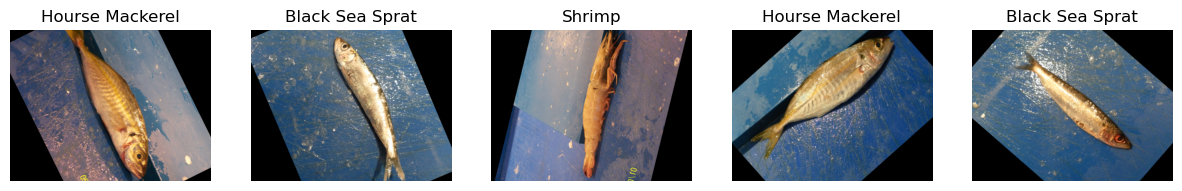

In [3]:
# Part 1: Describe the data
base_dir = "C:/Users/HP/Desktop/fish-classification/a-large-scale-fish-dataset/Fish_Dataset"

# Data collection
def collect_images_and_labels(directory):
    images = []
    labels = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.png') and 'GT' not in root:
                images.append(os.path.join(root, file))
                labels.append(root.split(os.sep)[-1])
    return images, labels

images, labels = collect_images_and_labels(base_dir)

# Visualization
def show_sample_images(images, labels, num_images=5):
    sample_indices = random.sample(range(len(images)), num_images)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for ax, idx in zip(axes, sample_indices):
        img_path = images[idx]
        label = labels[idx]
        image = Image.open(img_path)
        ax.imshow(image)
        ax.set_title(label)
        ax.axis('off')
    plt.show()

# Show some images from the dataset
show_sample_images(images, labels)

In [4]:
# Function to split data into train, validation, and test sets
def split_data(images, labels, train_frac=0.7, val_frac=0.15):
    data = list(zip(images, labels))
    random.shuffle(data)
    
    total_size = len(data)
    train_size = int(total_size * train_frac)
    val_size = int(total_size * val_frac)

    train_data = data[:train_size]
    val_data = data[train_size:train_size + val_size]
    test_data = data[train_size + val_size:]

    return train_data, val_data, test_data

# Splitting the data
train_data, val_data, test_data = split_data(images, labels)

print(f"Total images: {len(images)}")
print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")

Total images: 9000
Training set size: 6300
Validation set size: 1350
Test set size: 1350


In [5]:
# Define a transformation for the images
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to a fixed size
    transforms.ToTensor()           # Convert images to PyTorch tensors
])

In [6]:
class FishDataset(Dataset):
    def __init__(self, data, label_map, transform=None):
        self.data = data
        self.label_map = label_map
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = self.label_map[label]
        return image, label

# Create a label map
unique_labels = set(labels)
label_map = {label: idx for idx, label in enumerate(unique_labels)}

# Apply label map to datasets
train_dataset = FishDataset(train_data, label_map, transform=transform)
val_dataset = FishDataset(val_data, label_map, transform=transform)
test_dataset = FishDataset(test_data, label_map, transform=transform)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [7]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
# Part 2: Construct and run the CNN
class OptimizedCNN(nn.Module):
    def __init__(self):
        super(OptimizedCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256 * 16 * 16, 1024)  # Adjust the input features
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 9)  # There are 9 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 256 * 16 * 16)  # Adjust the flattening
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

model = OptimizedCNN()
model.to(device)

OptimizedCNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=65536, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=9, bias=True)
)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
for epoch in range(10):  # Run 10 epochs
    model.train()
    train_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
    
    # Calculate average training loss per epoch
    train_loss = train_loss / len(train_loader.dataset)

    # Validation phase
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    # Calculate average validation loss and accuracy
    val_loss = val_loss / len(val_loader.dataset)
    val_accuracy = 100 * correct / total

    print(f'Epoch {epoch+1}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

Epoch 1, Training Loss: 1.4710, Validation Loss: 0.7549, Validation Accuracy: 72.67%
Epoch 2, Training Loss: 0.5808, Validation Loss: 0.3174, Validation Accuracy: 89.63%
Epoch 3, Training Loss: 0.2842, Validation Loss: 0.1954, Validation Accuracy: 93.04%
Epoch 4, Training Loss: 0.1773, Validation Loss: 0.1183, Validation Accuracy: 96.30%
Epoch 5, Training Loss: 0.1209, Validation Loss: 0.1134, Validation Accuracy: 95.85%
Epoch 6, Training Loss: 0.0891, Validation Loss: 0.0779, Validation Accuracy: 98.00%
Epoch 7, Training Loss: 0.0674, Validation Loss: 0.0686, Validation Accuracy: 98.15%
Epoch 8, Training Loss: 0.0767, Validation Loss: 0.1053, Validation Accuracy: 96.74%
Epoch 9, Training Loss: 0.0484, Validation Loss: 0.0653, Validation Accuracy: 98.15%
Epoch 10, Training Loss: 0.0568, Validation Loss: 0.0756, Validation Accuracy: 97.93%


In [11]:
model.eval()
test_loss = 0
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate average test loss and accuracy
test_loss = test_loss / len(test_loader.dataset)
test_accuracy = 100 * correct / total

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

Test Loss: 0.0801, Test Accuracy: 97.26%


In [12]:
'''
Part 3: Use a different dataset to check the trained model's generalizability
The online-dataset is a small labelled dataset consists of images downloaded from online source
'''
def collect_images_and_labels_online(directory):
    images = []
    labels = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.jpg') and 'GT' not in root:
                images.append(os.path.join(root, file))
                labels.append(root.split(os.sep)[-1])
    return images, labels

In [13]:
online_data_dir = Path("C:/Users/HP/Desktop/fish-classification/online-dataset")
online_images, online_labels = collect_images_and_labels_online(online_data_dir)

online_dataset = FishDataset(list(zip(online_images, online_labels)), label_map, transform=transform)
online_loader = DataLoader(online_dataset, batch_size=32, shuffle=False)

# Expected output: 15 15
print(len(online_images), len(online_labels))

15 15


In [14]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in online_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

online_accuracy = 100 * correct / total
print(f'Accuracy on online dataset: {online_accuracy:.2f}%')

Accuracy on online dataset: 20.00%


In [15]:
'''
Part 4: Conclusion

In this project, a Convolutional Neural Network (CNN) was developed to classify and segment various types of fish 
using a large-scale dataset from Izmir University of Economics. 
    
The dataset comprised a range of seafood types, which were augmented to enhance the model's training. 

The CNN demonstrated high accuracy on this dataset. 
    
However, when the model was tested on a small, externally sourced dataset of fish images, 
it exhibited a significant drop in accuracy. 

This outcome highlights a limitation in the model's generalizability to new and diverse data sets. 

The results suggest that while the model is highly effective within the scope of the original dataset, 
its ability to adapt to different types of fish images not included in the training phase is constrained. 

Future efforts will focus on improving the model's generalizability, potentially through methods like expanding the training dataset.
'''

"\nPart 4: Conclusion\n\nIn this project, a Convolutional Neural Network (CNN) was developed to classify and segment various types of fish \nusing a large-scale dataset from Izmir University of Economics. \n    \nThe dataset comprised a range of seafood types, which were augmented to enhance the model's training. \n\nThe CNN demonstrated high accuracy on this dataset, with a training loss of 0.0547, validation loss of 0.0575, \nvalidation accuracy of 98.44%, and test accuracy of 97.70%. \n    \nHowever, when the model was tested on a small, externally sourced dataset of fish images, \nit exhibited a significant drop in accuracy. \n\nThis outcome highlights a limitation in the model's generalizability to new and diverse data sets. \n\nThe results suggest that while the model is highly effective within the scope of the original dataset, \nits ability to adapt to different types of fish images not included in the training phase is constrained. \n\nFuture efforts will focus on improving th